# Tutorial - https://coderzcolumn.com/tutorials/artificial-intelligence/word-embeddings-for-pytorch-text-classification-networks

In [1]:
import torch
import torchtext
import shap


c:\Users\nati\Desktop\Implementations\ImplementationsVenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
shap.initjs()

# Preparing the Dataset

In [3]:
from torch.utils.data import DataLoader,Dataset
train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()

In [6]:
for sample in train_dataset:
    print(sample)
    break

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


## Tokenize Text Data and Build Vocabulary

In [7]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import re

def tokenizer(inp_str): ## This method is one way of creating tokenizer that looks for word tokens
    return re.findall(r"\w+", inp_str)

tokenizer = get_tokenizer("basic_english") ## We'll use tokenizer available from PyTorch

def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text) # Yield are good for when we want to iterate over a sequence but dont want to store the entire sequence in memory
                                    # Similar to return but returns a generator object instead of values

vocab = build_vocab_from_iterator(build_vocab([train_dataset, test_dataset]), specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"]) # Whenever Out Of Vocabulary in encountered , will be inserted to dict["<UNK>"]

Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.


In [8]:
print(f"Length of the vocabulary is {len(vocab)}")

Length of the vocabulary is 98635


In [9]:
# Example of the Tokenizer
tokens = tokenizer("Hello how are you?")
indexes = vocab(tokens)
tokens, indexes

(['hello', 'how', 'are', 'you', '?'], [12388, 355, 42, 164, 80])

## Create DataLoader and Vectorize the Data

In [10]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(sample)) for sample in X]
    X = [sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X] ## Bringing all samples to 50 length.
    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1 ## We have deducted 1 from target names to get them in range [0,1,2,3,5] from [1,2,3,4,5]

train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=1024, collate_fn=vectorize_batch)

In [11]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 50]) torch.Size([1024])


## Approach 1 - Word Embeddings

In [12]:
from torch import nn
from torch.nn import functional as F

class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Embedding(num_embeddings=len(vocab), embedding_dim=25),

            nn.Flatten(),
            # After flattening - since each sentence is of length 50(words) and each word is represented as 25 Dimensional Embedding Vector
            # We get 25*50 = 1250 Input size for the fully connecter layer
            nn.Linear(25*50, 128), ## 25 = embeding length, 50 = words we kept per text example
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

## Training the Model

In [14]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [15]:
from torch.optim import Adam

epochs = 5
learning_rate = 0.003

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:05<00:00, 21.75it/s]


Train Loss : 1.017
Valid Loss : 0.660
Valid Acc  : 0.742


100%|██████████| 118/118 [00:05<00:00, 21.87it/s]


Train Loss : 0.501
Valid Loss : 0.476
Valid Acc  : 0.831


100%|██████████| 118/118 [00:05<00:00, 22.13it/s]


Train Loss : 0.323
Valid Loss : 0.443
Valid Acc  : 0.851


100%|██████████| 118/118 [00:05<00:00, 23.17it/s]


Train Loss : 0.216
Valid Loss : 0.491
Valid Acc  : 0.857


100%|██████████| 118/118 [00:05<00:00, 22.37it/s]


Train Loss : 0.146
Valid Loss : 0.580
Valid Acc  : 0.852


In [16]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8515789473684211

Classification Report : 
              precision    recall  f1-score   support

       World       0.87      0.85      0.86      1900
      Sports       0.95      0.90      0.93      1900
    Business       0.76      0.84      0.80      1900
    Sci/Tech       0.84      0.81      0.83      1900

    accuracy                           0.85      7600
   macro avg       0.86      0.85      0.85      7600
weighted avg       0.86      0.85      0.85      7600


Confusion Matrix : 
[[1620   50  169   61]
 [  84 1711   68   37]
 [  93   13 1600  194]
 [  67   24  268 1541]]


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Business'),
  Text(1, 0, 'Sci/Tech'),
  Text(2, 0, 'Sports'),
  Text(3, 0, 'World')])

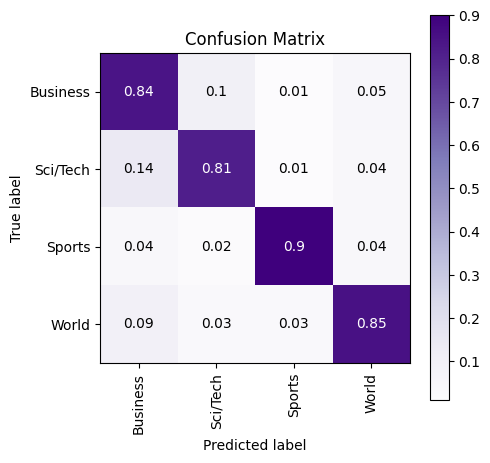

In [19]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    )
plt.xticks(rotation=90)

## Explaining Predictions with the use of SHAP (Game Theory approach)

In [20]:
def make_predictions(X_batch_text):
    X_batch = [vocab(tokenizer(sample)) for sample in X_batch_text]
    X_batch = [sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X_batch] ## Bringing all samples to 50 length.
    X_batch = torch.tensor(X_batch, dtype=torch.int32)
    logits_preds = embed_classifier(X_batch)
    return F.softmax(logits_preds, dim=-1).detach().numpy()

masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker, output_names=target_classes)

explainer

In [21]:
X_test, Y_test = [], []
for Y, X in test_dataset: ## Selecting first 1024 samples from test data
    X_test.append(X)
    Y_test.append(Y-1) ## Please make a Note that we have subtracted 1 from target values to start index from 0 instead of 1.

X_batch = [vocab(tokenizer(sample)) for sample in X_test[:2]]
X_batch = torch.tensor([sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X_batch], dtype=torch.int32)
logits = embed_classifier(X_batch)
preds_proba = F.softmax(logits, dim=-1)
preds = preds_proba.argmax(dim=-1)


print("Actual    Target Values : {}".format([target_classes[target] for target in Y_test[:2]]))
print("Predicted Target Values : {}".format([target_classes[target] for target in preds]))
print("Predicted Probabilities : {}".format(preds_proba.max(dim=-1)))

Actual    Target Values : ['Business', 'Sci/Tech']
Predicted Target Values : ['Business', 'Sci/Tech']
Predicted Probabilities : torch.return_types.max(
values=tensor([0.8295, 1.0000], grad_fn=<MaxBackward0>),
indices=tensor([2, 3]))


In [22]:
shap_values = explainer(X_test[:2])
shap.text_plot(shap_values)

## Trying Word Embedding with Longer Embedding Representation for each Word

In [25]:
class EmbeddingClassifier_2(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier_2, self).__init__()
        self.seq = nn.Sequential(
            nn.Embedding(num_embeddings=len(vocab), embedding_dim=40),

            nn.Flatten(),

            nn.Linear(40*50, 128), ## 40 = embeding length, 50 = words we kept per sample
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [26]:
epochs = 5
learning_rate = 0.003

loss_fn = nn.CrossEntropyLoss()
embed_classifier_2 = EmbeddingClassifier_2()
optimizer = Adam(embed_classifier_2.parameters(), lr=learning_rate)

TrainModel(embed_classifier_2, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:06<00:00, 19.07it/s]


Train Loss : 0.998
Valid Loss : 0.625
Valid Acc  : 0.764


100%|██████████| 118/118 [00:06<00:00, 19.04it/s]


Train Loss : 0.448
Valid Loss : 0.443
Valid Acc  : 0.844


100%|██████████| 118/118 [00:05<00:00, 19.83it/s]


Train Loss : 0.268
Valid Loss : 0.420
Valid Acc  : 0.865


100%|██████████| 118/118 [00:06<00:00, 19.34it/s]


Train Loss : 0.174
Valid Loss : 0.482
Valid Acc  : 0.868


100%|██████████| 118/118 [00:06<00:00, 18.87it/s]


Train Loss : 0.128
Valid Loss : 0.541
Valid Acc  : 0.872


## Evaluation

In [27]:
Y_actual, Y_preds = MakePredictions(embed_classifier_2, test_loader)
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.871578947368421

Classification Report : 
              precision    recall  f1-score   support

       World       0.89      0.87      0.88      1900
      Sports       0.91      0.96      0.93      1900
    Business       0.85      0.81      0.83      1900
    Sci/Tech       0.83      0.85      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600


Confusion Matrix : 
[[1661   85   83   71]
 [  36 1816   28   20]
 [  89   37 1537  237]
 [  71   57  162 1610]]


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Business'),
  Text(1, 0, 'Sci/Tech'),
  Text(2, 0, 'Sports'),
  Text(3, 0, 'World')])

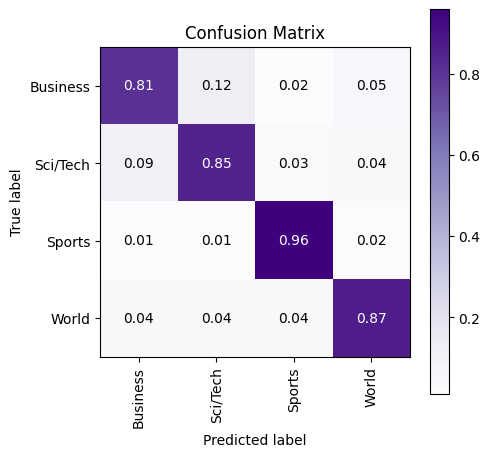

In [28]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    )
plt.xticks(rotation=90)

In [29]:
X_batch = [vocab(tokenizer(sample)) for sample in X_test[:2]]
X_batch = torch.tensor([sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X_batch], dtype=torch.int32)
logits = embed_classifier_2(X_batch)
preds_proba = F.softmax(logits, dim=-1)
preds = preds_proba.argmax(dim=-1)

print("Actual    Target Values : {}".format([target_classes[target] for target in Y_test[:2]]))
print("Predicted Target Values : {}".format([target_classes[target] for target in preds]))
print("Predicted Probabilities : {}".format(preds_proba.max(dim=-1)))

Actual    Target Values : ['Business', 'Sci/Tech']
Predicted Target Values : ['Business', 'Sci/Tech']
Predicted Probabilities : torch.return_types.max(
values=tensor([0.8886, 1.0000], grad_fn=<MaxBackward0>),
indices=tensor([2, 3]))


In [30]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker, output_names=target_classes)
shap_values = explainer(X_test[:2])
shap.text_plot(shap_values)

# Approach 3 - Average Word Embedding
### Instead of keeping an embedding for each token we will average the embeddings of all the tokens in a sentence example

In [31]:
class EmbeddingClassifier_3(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.word_embeddings = nn.Embedding(num_embeddings=len(vocab), embedding_dim=25)
        self.linear1 = nn.Linear(25, 128) ## 25 = embeding length, 50 = words we kept per sample
        self.linear2 = nn.Linear(128,64)
        self.linear3 = nn.Linear(64, len(target_classes))

    def forward(self, X_batch):
        x = self.word_embeddings(X_batch)
        x = x.mean(dim=1) ## Averaging embeddings

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        logits = F.relu(self.linear3(x))

        return logits

In [33]:
epochs = 5
learning_rate = 0.003

loss_fn = nn.CrossEntropyLoss()
embed_classifier_3 = EmbeddingClassifier()
optimizer = Adam(embed_classifier_3.parameters(), lr=learning_rate)

TrainModel(embed_classifier_3, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:06<00:00, 18.96it/s]


Train Loss : 0.976
Valid Loss : 0.604
Valid Acc  : 0.770


100%|██████████| 118/118 [00:06<00:00, 18.67it/s]


Train Loss : 0.444
Valid Loss : 0.441
Valid Acc  : 0.845


100%|██████████| 118/118 [00:06<00:00, 19.40it/s]


Train Loss : 0.272
Valid Loss : 0.471
Valid Acc  : 0.853


100%|██████████| 118/118 [00:06<00:00, 19.49it/s]


Train Loss : 0.175
Valid Loss : 0.485
Valid Acc  : 0.869


100%|██████████| 118/118 [00:06<00:00, 19.33it/s]


Train Loss : 0.124
Valid Loss : 0.614
Valid Acc  : 0.858


In [34]:

Y_actual, Y_preds = MakePredictions(embed_classifier_3, test_loader)

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8576315789473684

Classification Report : 
              precision    recall  f1-score   support

       World       0.90      0.84      0.87      1900
      Sports       0.95      0.91      0.93      1900
    Business       0.74      0.90      0.81      1900
    Sci/Tech       0.87      0.78      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.87      0.86      0.86      7600
weighted avg       0.87      0.86      0.86      7600


Confusion Matrix : 
[[1597   55  183   65]
 [  67 1724   73   36]
 [  45   18 1709  128]
 [  61   20  331 1488]]


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Business'),
  Text(1, 0, 'Sci/Tech'),
  Text(2, 0, 'Sports'),
  Text(3, 0, 'World')])

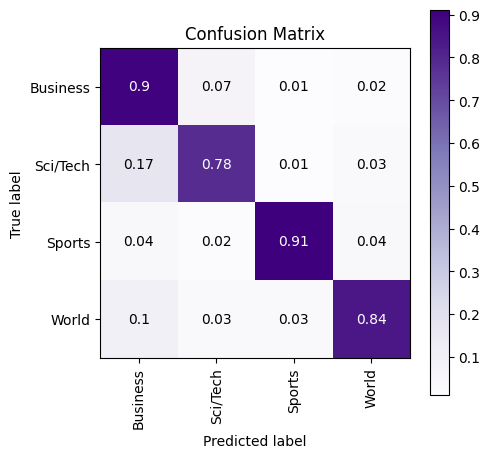

In [35]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    )
plt.xticks(rotation=90)

In [36]:
X_batch = [vocab(tokenizer(sample)) for sample in X_test[:2]]
X_batch = torch.tensor([sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X_batch], dtype=torch.int32)
logits = embed_classifier_3(X_batch)
preds_proba = F.softmax(logits, dim=-1)
preds = preds_proba.argmax(dim=-1)

print("Actual    Target Values : {}".format([target_classes[target] for target in Y_test[:2]]))
print("Predicted Target Values : {}".format([target_classes[target] for target in preds]))
print("Predicted Probabilities : {}".format(preds_proba.max(dim=-1)))

Actual    Target Values : ['Business', 'Sci/Tech']
Predicted Target Values : ['Business', 'Sci/Tech']
Predicted Probabilities : torch.return_types.max(
values=tensor([0.9713, 1.0000], grad_fn=<MaxBackward0>),
indices=tensor([2, 3]))


In [37]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker, output_names=target_classes)
shap_values = explainer(X_test[:2])
shap.text_plot(shap_values)

# Approach 4 EmbeddingBag Layer

In [40]:
class EmbeddingClassifier_4(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier_4, self).__init__()
        self.seq = nn.Sequential(
            nn.EmbeddingBag(num_embeddings=len(vocab), embedding_dim=25, mode="mean"),

            nn.Linear(25, 128), ## 25 = embeding length, 50 = words we kept per sample
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [41]:
epochs = 5
learning_rate = 0.003

loss_fn = nn.CrossEntropyLoss()
embed_classifier_4 = EmbeddingClassifier_4()
optimizer = Adam(embed_classifier_4.parameters(), lr=learning_rate)

TrainModel(embed_classifier_4, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:05<00:00, 22.31it/s]


Train Loss : 1.019
Valid Loss : 0.607
Valid Acc  : 0.766


100%|██████████| 118/118 [00:05<00:00, 22.27it/s]


Train Loss : 0.480
Valid Loss : 0.426
Valid Acc  : 0.846


100%|██████████| 118/118 [00:05<00:00, 21.70it/s]


Train Loss : 0.345
Valid Loss : 0.362
Valid Acc  : 0.874


100%|██████████| 118/118 [00:05<00:00, 20.30it/s]


Train Loss : 0.279
Valid Loss : 0.334
Valid Acc  : 0.883


100%|██████████| 118/118 [00:05<00:00, 21.76it/s]


Train Loss : 0.235
Valid Loss : 0.323
Valid Acc  : 0.891


In [42]:
Y_actual, Y_preds = MakePredictions(embed_classifier_4, test_loader)

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8907894736842106

Classification Report : 
              precision    recall  f1-score   support

       World       0.91      0.89      0.90      1900
      Sports       0.95      0.96      0.96      1900
    Business       0.82      0.88      0.85      1900
    Sci/Tech       0.89      0.83      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600


Confusion Matrix : 
[[1694   58  111   37]
 [  43 1824   16   17]
 [  68   11 1676  145]
 [  61   24  239 1576]]


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Business'),
  Text(1, 0, 'Sci/Tech'),
  Text(2, 0, 'Sports'),
  Text(3, 0, 'World')])

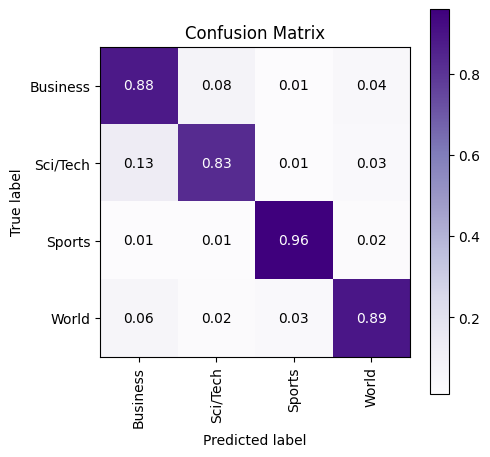

In [43]:

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    )
plt.xticks(rotation=90)